<a href="https://colab.research.google.com/github/raudh1/LorenzModel/blob/main/GenTrajMLPLorenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from random import randint
import os
import sys
import string
#from torch import Dataset, Dataloader
from numpy import linalg as LA
from torchsummary import summary
from numpy.core.defchararray import asarray
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.offsetbox import AnchoredText

In [2]:
from torch.autograd import grad
import pandas as pd


In [3]:
from matplotlib import pyplot as plt

In [4]:
import torch.nn.functional as F


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set files and directories

In [6]:
torch.set_default_tensor_type('torch.DoubleTensor')
mypath="./drive/MyDrive/exp/"

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda')
else: 
    device = torch.device('cpu')

print("device=",device)

device= cpu


In [9]:
#DEFINE MLP
class Model(nn.Module):
  
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(3, 60, bias=True)
        self.lin2 = nn.Linear(60, 42, bias=True)
        self.lin3 = nn.Linear(42, 3, bias=True)

    def forward(self, xb):
        x = xb.contiguous().view(-1, 3)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        

        return self.lin3(x).view(-1,1,3)              # if you use 9 traj instead of 1 use 9 

    def predict(self,input,N=100):
      
      output=torch.zeros(N+input.shape[0],1,3)
      traj_pred= self.forward(input)

      
      output[:len(traj_pred)]=traj_pred
      inp=traj_pred[-1]

      for i in range(len(traj_pred),N+len(traj_pred)):
        inp=self.forward(inp)
        output[i]=inp

      return output

    

In [46]:
if __name__ == '__main__':

    # load data and make training set
    hidden   = 32
    layer    = 2
    features = 3
    dropout  = 0
    # build the model        
    ini = 25
case = 'FULL'


In [47]:
def load_data(case,sampling=5):
  if (case=='MANI'or case=='PART' ):

    name=mypath+'/'+case+'_'+str(k)+'.npy'
    data = np.load(name).astype('float64')
    data=np.moveaxis(data,-1,0)
    data=data[:,:1,:]                    # one of 9 trajectories

    return data[::sampling]

  elif (case=='other'):
    name= mypath+'/other_traj.npy'
    data = np.load(name).astype('float64')
    data=np.moveaxis(data,-1,0)
    data=data[:,:1,:]

    return data[::sampling]
  elif (case=='zero'):
    name=mypath+'/zeros_traj.npy'
    data = np.load(name).astype('float64')

    data=np.moveaxis(data,-1,0)
    data=data[:,:1,:]

    return data[::sampling]
  elif (case=='FULL'):
    name=mypath+'/'+case+'_'+str(k)+'.npy'
    data = np.load(name).astype('float64')
    data = np.expand_dims(data.T, axis=1)
    data=data[:,:1,:]
    #print(data.shape[:])

    return data[::sampling]

**TRAIN**

In [243]:
k=0

data=load_data(case,1)
print(data.shape)
#print(data.dtype)

input  = torch.from_numpy(data[:-1,:,:]).double().to(device)
target = torch.from_numpy(data[1:,:,:]).double().to(device)
      
seq = Model().double().to(device)

def train(model=seq,input=input,target=target,lr=1e-3,epoch=50):

      print('input shape=',input.shape," target shape =",target.shape)
      criterion = nn.MSELoss(reduction='mean')
      optimizer = optim.Adam(model.parameters(), lr) #learning rate fixed#
  
  
      err = 10
      loss1 = 1
      i = 0
      
      #len_train=epoch
      loss_grad=[]
      train_loss= np.zeros(epoch)
      i=0

      while i<epoch: #old step counter
          optimizer.zero_grad()


          out =model(input)
          loss = criterion(out, target.to(device))
          loss.backward()
          train_loss[i] = loss.item()

          optimizer.step()
          

          if i%(50)==0:
              loss2 = loss
              err = np.abs(loss2.item()-loss1)/10
              loss1 = loss2.item()
              print(i, 'train loss:', loss2.item())
          i += 1
          sys.stdout.flush() 
      
      print("last epoch: ", i)
      

      return train_loss

(27000, 1, 3)


In [244]:
loss=train(lr=0.01,epoch=600)

input shape= torch.Size([26999, 1, 3])  target shape = torch.Size([26999, 1, 3])
0 train loss: 235.1707255029834
50 train loss: 0.45421546778964816
100 train loss: 0.0992831063626436
150 train loss: 0.06938649763574142
200 train loss: 0.049402509604215626
250 train loss: 0.04080725000189752
300 train loss: 0.030709668265680428
350 train loss: 0.02906916195177464
400 train loss: 0.02388588246577648
450 train loss: 0.021472321998388395
500 train loss: 0.05098930705392907
550 train loss: 0.01784284788831948
last epoch:  600


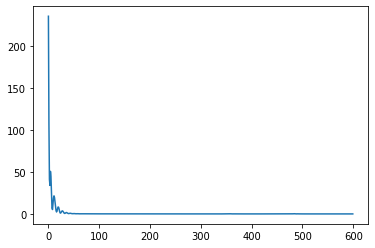

In [245]:
plt.plot(loss)

In [172]:
def generate(model,history,future):

  return model.predict(input[:history],N=future)

In [264]:
history=1000
future=500
traj=generate(seq,history,future).detach().numpy()
traj_1step=seq(input[:(history+future)]).detach().numpy()

**PLOT**

In [267]:
def plot_traj(history,traj_1step,traj,coordinate='x'):
  if coordinate=='x':
    i=0
  if coordinate=='y':
    i=1
  if coordinate=='z':
    i=2

  plt.figure(figsize=(14.4,8.8))
  plt.plot(traj_1step[:,0,i],label='1step model')
  plt.plot(traj[:,0,i],label='traj_generate')
  #plt.plot(input[:,0,i],label='reql data')

  plt.scatter(history,seq(input)[history,0,i].detach().numpy(),color='red')

  plt.xlim(history-history//2,len(traj))
  plt.ylabel(rf'${coordinate}(t)$',fontsize=20)
  plt.xlabel(r'$t$',fontsize=20)
  plt.legend()
  plt.show()


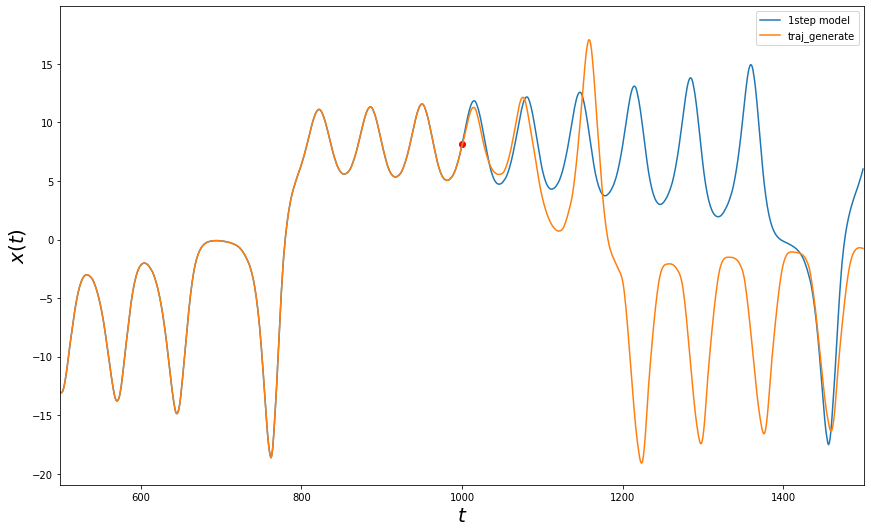

In [283]:
plot_traj(history,traj_1step=traj_1step,traj=traj,coordinate='x')

In [284]:
print(len(traj),len(traj_1step))

1500 1500


In [294]:
def plot_3D(traj,traj_1step,history,length=1000):
  fig = plt.figure(figsize=(14,9))
  ax = fig.gca(projection="3d")
  start=history-100
  ax.plot(traj_1step[start:history+length,0,0],traj_1step[start:history+length,0,1],traj_1step[start:history+length,0,2],label='1 step traj',linestyle='--')
  ax.plot(traj[start:history+length,0,0],traj[start:history+length,0,1],traj[start:history+length,0,2],label='generated traj')
  ax.scatter3D(traj[history,0,0],traj[history,0,1],traj[history,0,2],c='green',label='starting point')
  ax.set_xlabel(r'$x$',fontsize=35)
  ax.set_ylabel(r'$y$',fontsize=35)
  ax.set_zlabel(r'$z$',fontsize=35)

  ax.legend(fontsize=15)

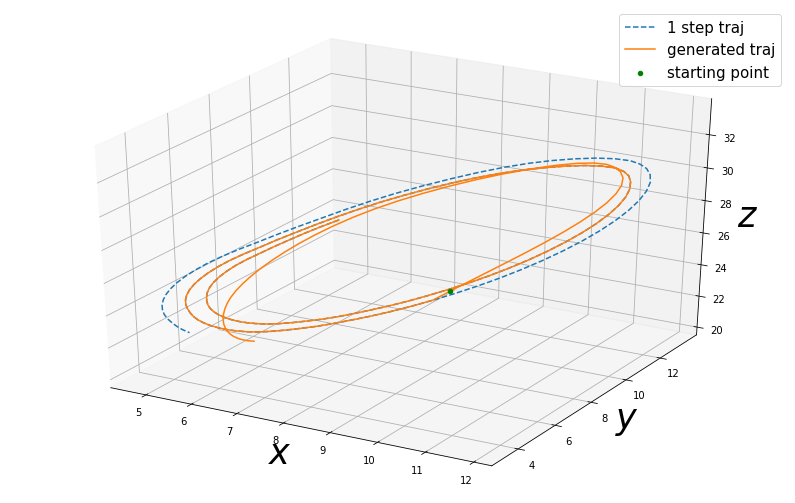

In [295]:
plot_3D(traj,traj_1step,history=history,length=50)